### Simple Olympic medal table analysis with iPython, Pandas, matplotlib

1) Scrape medal tables from wikipedia

2) Clean data with Pandas

3) Basic matplotlib to visualise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import html5lib, lxml
#pd.set_option('max_columns', 50)
%matplotlib inline
import sys
getsize=sys.getsizeof
import seaborn as sns  #need to pip install
#!pip install --upgrade html5lib==1.0b8 ## this was requirered due to bug in html5lib new version
params = {'legend.fontsize': 'x-large',
         'figure.figsize': (12, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'large',
         'figure.titlesize' : 'x-large'}
plt.rcParams.update(params)

In [2]:
from urllib.error import HTTPError
import time


def get_year(year):
    """ returns a dataframe of olympic medals for the year parameter"""
    url = 'https://en.wikipedia.org/wiki/XXXX_Summer_Olympics_medal_table'.replace('XXXX',str(year))
    try:
        df = pd.read_html(url, flavor='html5lib', attrs={'class': 'wikitable'}, header=0)[0]
    except HTTPError as exc:
        df=pd.DataFrame()
    else:
        df.insert(0,'Year', year)
        df.rename(columns={'NOC':'Nation'}, inplace=True)
    return df


def fix_data(df):
    """ corrects olypic medal dataframe """
    df.drop(df.index[df.Rank.str.startswith('Total')], inplace=True) # drop total rows inplace
    
    # change to str to enable string operation on bad values in integer columns
    df.Rank = df.Rank.astype(str)
    df.Gold = df.Gold.astype(str)
    df.Silver = df.Silver.astype(str)
    df.Bronze = df.Bronze.astype(str)
    
    #correct where countries had a draw and data is shifted left by one column
    draws = ~df.Rank.str.isnumeric()
    df.loc[draws, 'Total'] = df.Bronze[draws]
    df.loc[draws, 'Bronze'] = df.Silver[draws]
    df.loc[draws, 'Silver'] = df.Gold[draws]
    df.loc[draws, 'Nation'] = df.Rank[draws]
    df.loc[draws, 'Rank'] = np.nan
    df['Rank'] = df['Rank'].ffill()
        
    # fix notes (nb[xx]) next to medal counts, and NOC subscripts
    df.Gold = df.Gold.str.replace('\[.*$', '')
    df.Silver = df.Silver.str.replace('\[.*$', '')
    df.Bronze = df.Bronze.str.replace('\[.*$', '')
    df.Nation = df.Nation.str.replace('\xa0.*$', '')
    
    # correct column types
    df.Year = df.Year.astype(np.int16) 
    df.Rank = df.Rank.astype(np.int16)  
    df.Nation = df.Nation.astype(str) 
    df.Gold = df.Gold.astype(np.int16)
    df.Silver = df.Silver.astype(np.int16)
    df.Bronze = df.Bronze.astype(np.int16)
    df.Total = df.Total.astype(np.int16)   
    return df


def get_data(from_year, to_year):   
    dft=pd.DataFrame()
    start=time.time()

    for year in range(from_year, to_year+1, 4):
        if year == 2008: continue # skip due to corrupt year table
        df = get_year(year)
        dft = dft.append(df, ignore_index=True)
    
    end = time.time()
    print('Olympics Dataframe load complete in %4.1f seconds' % (end - start))
    return dft

# %debug get_data()

In [3]:
df_raw = get_data(1896, 2016)
df = fix_data(df_raw.copy())

Olympics Dataframe load complete in 12.5 seconds


In [4]:
df = fix_data(df_raw.copy())
df.head()

,Year,Rank,Nation,Gold,Silver,Bronze,Total
0,1896,1,United States,11,7,2,20
1,1896,2,Greece,10,17,19,46
2,1896,3,Germany,6,5,2,13
3,1896,4,France,5,4,2,11
4,1896,5,Great Britain,2,3,2,7


In [5]:
britain = df[df.Nation=='Great Britain']
australia = df[df.Nation=='Australia']
usa = df[df.Nation=='United States']
germany = df[df.Nation=='Germany']
interesting = pd.concat([britain, australia, usa, germany])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 0 to 1185
Data columns (total 7 columns):
Year      1160 non-null int16
Rank      1160 non-null int16
Nation    1160 non-null object
Gold      1160 non-null int16
Silver    1160 non-null int16
Bronze    1160 non-null int16
Total     1160 non-null int16
dtypes: int16(6), object(1)
memory usage: 31.7+ KB


In [6]:
interesting.groupby('Nation').mean()

,Year,Rank,Gold,Silver,Bronze,Total
Nation,,,,,,
Australia,1962.666667,11.500000,5.541667,6.166667,7.083333,18.791667
Germany,1952.533333,6.066667,11.666667,12.133333,14.466667,38.266667
Great Britain,1956.592593,9.444444,9.037037,10.444444,10.148148,29.629630
United States,1955.692308,1.423077,37.923077,29.076923,25.692308,92.692308


In [7]:
df.describe()

,Year,Rank,Gold,Silver,Bronze,Total
count,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000
mean,1973.744828,26.972414,4.194828,4.118966,4.426724,12.695690
std,32.483678,19.545331,8.634460,7.278959,6.923206,22.126813
min,1896.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1952.000000,11.000000,0.000000,0.000000,1.000000,2.000000
50%,1980.000000,23.000000,1.000000,2.000000,2.000000,5.000000
75%,2000.000000,37.000000,4.000000,5.000000,5.000000,14.000000
max,2016.000000,79.000000,83.000000,82.000000,79.000000,239.000000


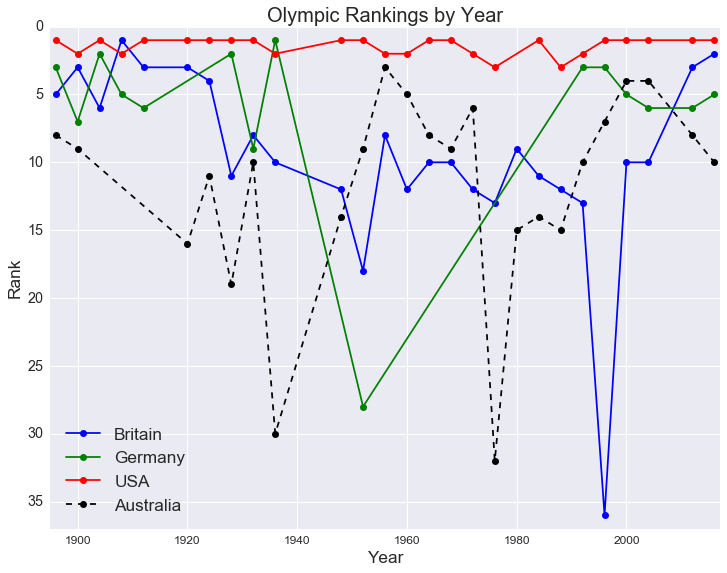

In [8]:
plt.ylim(britain.Rank.max()+1,0)
plt.xlim(britain.Year.min()-1,britain.Year.max()+1)
plt.title('Olympic Rankings by Year', fontsize=20)
plt.ylabel('Rank')
plt.xlabel('Year')
plt.plot(britain.Year, britain.Rank, 'b.-', marker='o', label='Britain')
plt.plot(germany.Year, germany.Rank, 'g.-', marker='o', label='Germany')
plt.plot(usa.Year, usa.Rank,  'r.-', marker='o', label='USA')
plt.plot(australia.Year, australia.Rank, 'k.--', marker='o', label='Australia')
plt.legend(loc='best')
print()